### Preparing data

In [78]:
import pandas as pd
import numpy as np

In [202]:
# Directory in which we have saved the data
data_directory = ""

# Read data
X_df = pd.read_csv(data_directory+"BASC197_X_corr.csv")
X = X_df.to_numpy()

Y_df = pd.read_csv(data_directory+"Y.csv")
Y = Y_df.to_numpy()
Y = Y.ravel()

### **Cross-validation**


In [203]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score


In [204]:
def cross_validation_func(model, param_grid, X, Y, masks, cv_outer):

    scores = dict()
    recall = []
    precision = []
    accuracy = []
    roc_auc = []
    best_params = []


    # Define cv splits
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
    
    i = 0

    # Complete steps
    for train_index, test_index in cv_outer.split(X, Y):
        
        X_train, X_test = X[train_index][:, masks[i]], X[test_index][:, masks[i]]

        Y_train, Y_test = Y[train_index], Y[test_index]

        # Define search
        search = GridSearchCV(model, param_grid=param_grid, scoring='accuracy', cv=cv_inner, refit=True, verbose=10)

        search.fit(X_train, Y_train)

        Y_pred = search.predict(X_test)

        roc_auc.append(roc_auc_score(Y_test,Y_pred))
        accuracy.append(accuracy_score(Y_test, Y_pred))
        recall.append(recall_score(Y_test,Y_pred))
        precision.append(precision_score(Y_test,Y_pred,average='weighted'))
        best_params.append(search.best_params_)
        
        i+=1

    scores["roc_auc"] = roc_auc
    scores["accuracy"] = accuracy
    scores["recall"] = recall
    scores["precision"] = precision
    scores["best_params"] = best_params
    

    return scores

In [205]:
def feature_selection(X, Y, cv_outer): 
    masks = list()

    anova_k = 5000
    step_features = 20

    for train_index, test_index in cv_outer.split(X, Y):
        X_train = X[train_index]
        Y_train = Y[train_index]

        anova = SelectKBest(score_func=f_classif, k=anova_k)
        X_train = anova.fit_transform(X_train,Y_train)

        mask_anova = anova.get_support()

        rfe = RFECV(estimator=SVC(kernel="linear",C=1), cv=cv_outer, step=step_features, verbose=True)
        rfe.fit(X_train, Y_train)
        
        mask_rfe = rfe.support_
        
        mask_pad = np.pad(mask_rfe, (0, len(mask_anova) - len(mask_rfe)), constant_values=False)
        combined_mask = np.logical_and(mask_anova, mask_pad)

        masks.append(combined_mask)

    return masks



### **Models**

In [8]:
# Take data to test (eliminate afterwards)
from sklearn.model_selection import train_test_split
X_example, X_test, Y_example, Y_test = train_test_split(
    X, Y, test_size=0.95, random_state=42, shuffle=True)

In [206]:
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [207]:
# Features masks for SVM, LR and XGBoost for each split
masks = feature_selection(X=X, Y=Y, cv_outer=cv_outer)

Fitting estimator with 5000 features.


Fitting estimator with 4980 features.
Fitting estimator with 4960 features.
Fitting estimator with 4940 features.
Fitting estimator with 4920 features.
Fitting estimator with 4900 features.
Fitting estimator with 4880 features.
Fitting estimator with 4860 features.
Fitting estimator with 4840 features.
Fitting estimator with 4820 features.
Fitting estimator with 4800 features.
Fitting estimator with 4780 features.
Fitting estimator with 4760 features.
Fitting estimator with 4740 features.
Fitting estimator with 4720 features.
Fitting estimator with 4700 features.
Fitting estimator with 4680 features.
Fitting estimator with 4660 features.
Fitting estimator with 4640 features.
Fitting estimator with 4620 features.
Fitting estimator with 4600 features.
Fitting estimator with 4580 features.
Fitting estimator with 4560 features.
Fitting estimator with 4540 features.
Fitting estimator with 4520 features.
Fitting estimator with 4500 features.
Fitting estimator with 4480 features.
Fitting esti

In [208]:
masks_df = pd.DataFrame(masks)
masks_df.to_csv('masks_results.csv', index=False)

In [209]:
masks = np.array(pd.read_csv("masks_results.csv"))

In [213]:
for i in range(5):
    print(f"Number of features for CV split {i}: {masks[i].sum()}")

Number of features for CV split 0: 392
Number of features for CV split 1: 122
Number of features for CV split 2: 671
Number of features for CV split 3: 200
Number of features for CV split 4: 252


#### SVM model

In [217]:
param_grid_svm = {'kernel': ['rbf', 'poly', 'sigmoid'], 'gamma': [0.01, 1e-3, 1e-4, 1e-5],'C': [0.001, 0.1, 10, 100, 1000]}
model_svm = SVC(probability=True, random_state=42)

scores_svm = cross_validation_func(model_svm, param_grid=param_grid_svm, X=X, Y=Y, masks=masks, cv_outer=cv_outer)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 1/5; 1/60] END C=0.001, gamma=0.01, kernel=rbf;, score=0.536 total time=   0.3s
[CV 2/5; 1/60] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 2/5; 1/60] END C=0.001, gamma=0.01, kernel=rbf;, score=0.540 total time=   0.3s
[CV 3/5; 1/60] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 3/5; 1/60] END C=0.001, gamma=0.01, kernel=rbf;, score=0.540 total time=   0.4s
[CV 4/5; 1/60] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 4/5; 1/60] END C=0.001, gamma=0.01, kernel=rbf;, score=0.540 total time=   0.4s
[CV 5/5; 1/60] START C=0.001, gamma=0.01, kernel=rbf............................
[CV 5/5; 1/60] END C=0.001, gamma=0.01, kernel=rbf;, score=0.540 total time=   0.3s
[CV 1/5; 2/60] START C=0.001, gamma=0.01, kernel=poly...........................
[CV 1/5; 2/60] END C=0.001, gamm

In [218]:
scores_svm_df = pd.DataFrame(scores_svm)
scores_svm_df.to_csv('svm_results.csv', index=False)

#### Logistic Regression

In [219]:
model_lr = LogisticRegression(random_state=42, solver="saga", max_iter=10000)
param_grid_lr ={"C":[0.01, 0.1, 10, 100, 1000], "penalty":["l1","l2"]}

In [221]:
scores_lr = cross_validation_func(model_lr, param_grid_lr, X, Y, masks=masks, cv_outer=cv_outer)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 1/5; 1/10] END ..........C=0.01, penalty=l1;, score=0.536 total time=   0.0s
[CV 2/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 2/5; 1/10] END ..........C=0.01, penalty=l1;, score=0.540 total time=   0.0s
[CV 3/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 3/5; 1/10] END ..........C=0.01, penalty=l1;, score=0.540 total time=   0.0s
[CV 4/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 4/5; 1/10] END ..........C=0.01, penalty=l1;, score=0.540 total time=   0.0s
[CV 5/5; 1/10] START C=0.01, penalty=l1.........................................
[CV 5/5; 1/10] END ..........C=0.01, penalty=l1;, score=0.540 total time=   0.0s
[CV 1/5; 2/10] START C=0.01, penalty=l2.........................................
[CV 1/5; 2/10] END ..........C=0.01, penalty=l2;

In [ ]:
scores_lr_df = pd.DataFrame(scores_lr)
scores_lr_df.to_csv('lr_results.csv', index=False)

#### XGBoost

In [ ]:
model_xgb = XGBClassifier(random_state=42)

param_grid_xgb = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
        }

In [ ]:
scores_xgb = cross_validation_func(model_xgb, param_grid_xgb, X=X, Y=Y, masks=masks, cv_outer=cv_outer)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[CV 1/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 1/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.571 total time=   0.3s
[CV 2/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 2/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.429 total time=   0.2s
[CV 3/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 3/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.571 total time=   0.1s
[CV 4/5; 1/405] START colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6
[CV 4/5; 1/405] END colsample_bytree=0.6, gamma=0.5, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.857 total time=   0

In [ ]:
scores_xgb_df = pd.DataFrame(scores_xgb)
scores_xgb_df.to_csv('xgb_results.csv', index=False)

#### ASD-DiagNet

### **Analysis**


In [174]:
import matplotlib.pyplot as plt

In [114]:
scores_svm_df = pd.read_csv("svm_results.csv")
scores_lr_df = pd.read_csv("lr_results.csv")
scores_xgb_df = pd.read_csv("xgb_results.csv")

In [117]:
# Create a summary DataFrame

svm_mean = scores_svm_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)
lr_mean = scores_lr_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)
xgb_mean = scores_xgb_df[["roc_auc", "precision", "recall", "accuracy"]].mean().round(4)

summary_df = pd.DataFrame({
    'Model': ['SVM', 'Logistic Regression', 'XGBoost'],
    'Accuracy': [svm_mean['accuracy'], lr_mean['accuracy'], xgb_mean['accuracy']],
    'Precision': [svm_mean['precision'], lr_mean['precision'], xgb_mean['precision']],
    'Recall': [svm_mean['recall'], lr_mean['recall'], xgb_mean['recall']],
    'ROC AUC': [svm_mean['roc_auc'], lr_mean['roc_auc'], xgb_mean['roc_auc']]
    
})

In [118]:
print(summary_df)

                 Model  Accuracy  Precision  Recall  ROC AUC
0                  SVM    0.6333     0.6727    0.76    0.630
1  Logistic Regression    0.5611     0.5882    0.53    0.565
2              XGBoost    0.5667     0.5770    0.58    0.565


In [119]:
# We look at the parameters and metrics of the best estimator for each CV split
print(scores_svm_df)

   roc_auc  accuracy  recall  precision  \
0    0.550  0.555556     0.6   0.555556   
1    0.650  0.666667     0.8   0.666667   
2    0.450  0.444444     0.4   0.455556   
3    0.875  0.875000     1.0   0.900000   
4    0.625  0.625000     1.0   0.785714   

                                       best_params  
0      {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}  
1  {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}  
2   {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}  
3      {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}  
4      {'C': 10, 'gamma': 0.001, 'kernel': 'poly'}  


After selecting the best model from the previous metrics, we train it with the whole dataset

In [134]:
# Best model
best_model = SVC(random_state=42, kernel="poly", C=100, gamma=0.01)

best_mask = masks[0]
X_selected = X_example[:,best_mask]

X_selected.shape


(43, 6288)

In [89]:
best_model.fit(X_selected, Y_example)

SVC(C=100, gamma=0.01, kernel='poly', random_state=42)

In [133]:
train_score = best_model.score(X_selected, Y_example)
print(f"Train accuracy on the whole dataset: {train_score.round(4)}")

Train accuracy on the whole dataset: 0.9302


In [146]:
# We import the atlas which was originally used for computing the data

from nilearn import datasets
from nilearn import plotting

basc_197 = datasets.fetch_atlas_basc_multiscale_2015(version='sym', resolution="197")

In [149]:
basc_197["maps"]

str

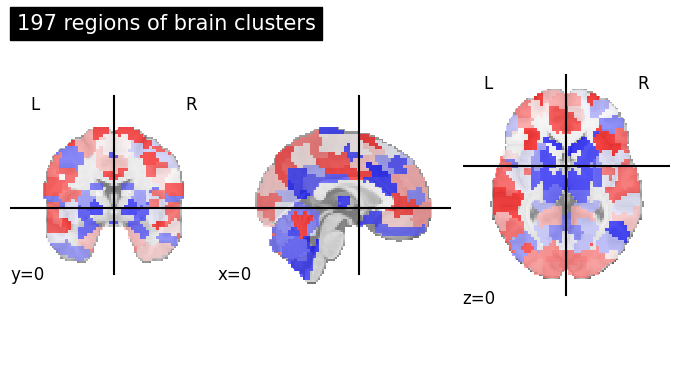

In [172]:
# Plotting the regions of interest of BASC197

plotting.plot_roi(
    basc_197["maps"], cmap=plotting.cm.bwr, title="197 regions of brain clusters", cut_coords=(0,0,0)
)

plotting.show()

In [150]:
from nilearn.maskers import NiftiLabelsMasker
masker = NiftiLabelsMasker(basc_197["maps"],
                           memory='nilearn_cache',
                           memory_level=1,
                           smoothing_fwhm=6,
                           detrend=True,
                           verbose=1,
                           reports=True)

  0%|          | 0/43 [00:00<?, ?it/s]

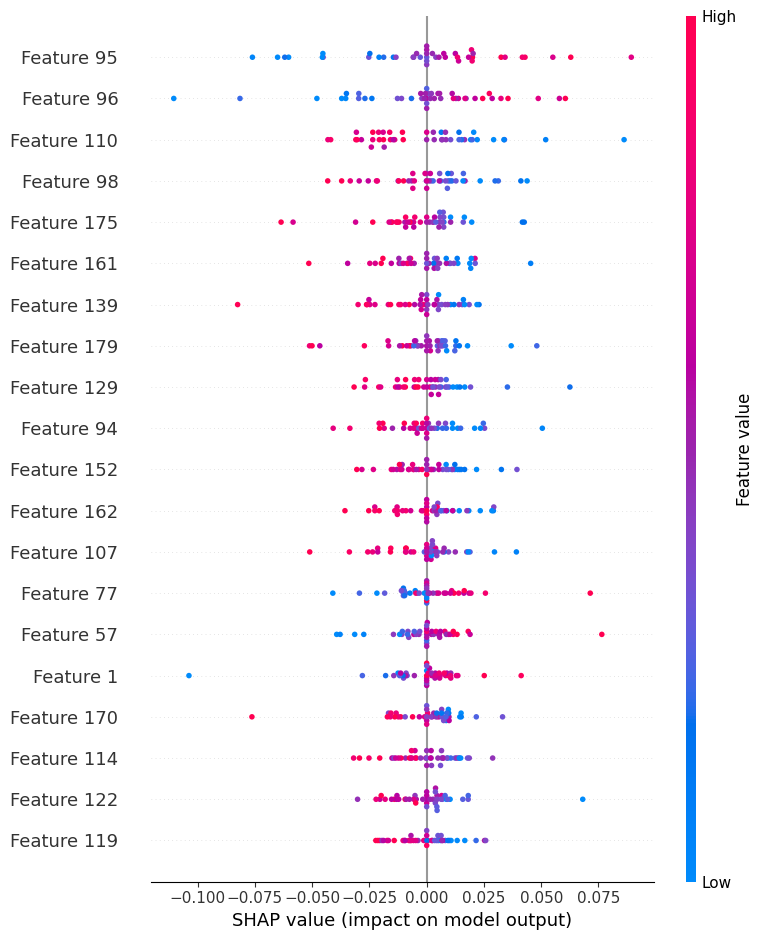

In [91]:
import shap
# Create a SHAP explainer for the model
explainer = shap.KernelExplainer(best_model.predict, X_selected)

# Calculate SHAP values
shap_values = explainer(X_selected)

# Visualize SHAP values
shap.summary_plot(shap_values, X_selected)

ValueError: 'adjacency_matrix' is supposed to have shape (n, n). Its shape was (1, 2)

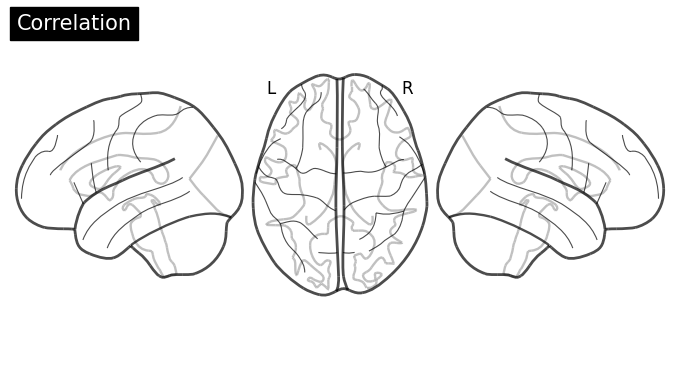

In [185]:
plotting.plot_connectome(
    np.array([[0,1]]),
    np.array([[2,1,3],[10,50,10]]),
    title="Correlation",
    display_mode="lzr",
)
plt.show()


### Tests

In [152]:
masker.fit()

report = masker.generate_report()
report

[NiftiLabelsMasker.fit] loading data from /home/juancruz/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale197.nii.gz


/home/juancruz/miniconda3/envs/neurodc/lib/python3.11/site-packages/nilearn/maskers/nifti_labels_masker.py:317: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)


label value,size (in mm^3),relative size (in %)
1,3753,0.24
2,4590,0.29
3,4752,0.3
4,3726,0.24
5,4266,0.27
6,3861,0.25
7,4482,0.29
8,3996,0.26
9,6588,0.42
10,11205,0.72


In [16]:
# Convert data to one DataFrame

def to_dataframe(X,Y):
    df_features = pd.DataFrame(X)

    # Convert the n x 1 array to a DataFrame
    df_labels = pd.DataFrame(Y)

    # Assign column names to the features DataFrame
    num_features = df_features.shape[1]
    feature_columns = [f'feature{i+1}' for i in range(num_features)]
    df_features.columns = feature_columns

    # Assign a column name to the labels DataFrame
    df_labels.columns = ['label']

    # Concatenate the two DataFrames
    data_df = pd.concat([df_features, df_labels], axis=1)

    return data_df, feature_columns

data_df, feature_columns = to_dataframe(X,Y)

In [186]:
from nilearn.datasets import fetch_abide_pcp

# Fetch the full data and update phenotypic data and cross_validation
abide = fetch_abide_pcp(derivatives = ['func_preproc'], pipeline = 'cpac', quality_checked = True, n_subjects=1)
y = abide.phenotypic['DX_GROUP']
y[y == 2] = 0
atlas = 'BASC197'

/home/juancruz/miniconda3/envs/neurodc/lib/python3.11/site-packages/nilearn/datasets/func.py:1201: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
time_series_basc197 = []
for i in range(len(abide.func_preproc)):
    time_series_basc197.append(masker.fit_transform(abide.func_preproc[i]))

In [193]:
from nilearn.connectome import ConnectivityMeasure
matrix_conect = ConnectivityMeasure(kind="correlation", vectorize=False)

In [196]:
abide

{'description': 'ABIDE\n\n\nNotes\n-----\nThe Autism Brain Imaging Data Exchange (ABIDE) dataset provides previously\ncollected resting state functional magnetic resonance imaging datasets\nfrom 539 individuals with ASD and 573 typical controls for the purpose\nof data sharing in the broader scientific community. This grass-root\ninitiative involved 16 international sites, sharing 20 samples yielding\n1112 datasets composed of both MRI data and an extensive array of\nphenotypic information common across nearly all sites (see below).\n\nNote that this is the preprocessed version of ABIDE provided by the\npreprocess connectome projects (PCP).\n\n\nContent\n-------\n    :\'phenotypic\': Behavioral information.\n\n\nReferences\n----------\n\nFor more information about this dataset\'s structure:\nhttp://preprocessed-connectomes-project.github.io\nhttp://www.childmind.org/en/healthy-brain-network/abide/\n\nNielsen, Jared A., et al. "Multisite functional connectivity MRI\nclassification of au

In [200]:
abide.func_preproc[0]

'/home/juancruz/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz'

In [201]:
matrix_conect.fit_transform(abide.func_preproc[0])

ValueError: Each subject must be 2D numpy.ndarray.
 You provided [<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]

In [192]:
time_series_basc197[0].shape

(196, 197)